# Notebook for evaluating trained CNNs
- Load trained LCU
- Select folder with eval data (idea is that test = patched and predict = not patched). So incorporate both ways.
- Create DL with same label mappings as original. 
- Predict those, figure out way to show images of memory-mapped images (ie predict set)
- Or just stick with test set up for now? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import pytorch_lightning as pl
import pickle
# import segmentation_models_pytorch as smp

path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
path_mapping_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl'
tmp_path_dict = pickle.load(open(path_mapping_dict, 'rb'))

# tmp_path_dict#['dict_new_names']

In [5]:
df_hab = lca.load_pols('../content/habitat_data_annotations/habitat_data_annotations.shp')
df_hab = df_hab[df_hab['SEL_TRAIN'] == 1]
print(len(df_hab))
# df_hab.head()
df_hab.groupby('Class_low').sum()


26


,SEL_TRAIN,area
Class_low,,
D1,6,3152340.320
D2a,7,5255077.822
F3a,3,6041197.782
F3d,10,450066.751


## Use trained CNN to make predictions of unseen data:

In [3]:
list_models = [x for x in os.listdir('/home/tplas/models/') if x[-5:] == '.data']
list_models.sort() 

list_info = []
for im, mn in enumerate(list_models):
    LCU = lcm.load_model(filename=mn, verbose=0)
    list_info.append((im, mn, str(LCU.loss), LCU.n_epochs_converged, LCU.dict_training_details['path_mapping_dict'].split('/')[-1].split('__')[1]))

In [4]:
df_info = pd.DataFrame(list_info, columns=['im', 'model_name', 'loss', 'n_epochs_converged', 'path_mapping_dict'])
df_info

,im,model_name,loss,n_epochs_converged,path_mapping_dict
0,0,LCU_2023-04-21-1335.data,CrossEntropyLoss(),61,C_subclasses_only
1,1,LCU_2023-04-21-1355.data,CrossEntropyLoss(),61,D_subclasses_only
2,2,LCU_2023-04-21-1418.data,CrossEntropyLoss(),61,E_subclasses_and_F3d_only
3,3,LCU_2023-04-21-1502.data,CrossEntropyLoss(),61,main_categories_F3inDE_noFGH
4,4,LCU_2023-04-21-1520.data,FocalLoss_2(),61,C_subclasses_only
5,5,LCU_2023-04-21-1541.data,FocalLoss_2(),61,D_subclasses_only
6,6,LCU_2023-04-21-1604.data,FocalLoss_2(),61,E_subclasses_and_F3d_only
7,7,LCU_2023-04-24-1114.data,FocalLoss_2(),61,main_categories_F3inDE_noFGH
8,8,LCU_2023-04-24-1132.data,CrossEntropyLoss(),61,C_subclasses_only
9,9,LCU_2023-04-24-1153.data,CrossEntropyLoss(),61,D_subclasses_only


In [3]:
LCU = lcm.load_model(filename='LCU_2023-03-23-2105.data')
# LCU = lcm.load_model(filename='LCU_2023-03-23-1750.data')

LCU.eval()
# ## From https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html#save-a-checkpoint

# ## LightningModule from checkpoint
# ## To load a LightningModule along with its weights and hyperparameters use the following method:

# model = LCU.load_from_checkpoint("/path/to/checkpoint.ckpt")


Loaded LCU_2023-03-23-2105
loss_function is focal_loss
n_max_epochs is 20
LandCoverUNet class using FocalLoss_2()
main_categories_F3inDE_noFGH training using randomly split eval patch data. focal_loss resnet50 60 epochs


Instance LCU_2023-03-23-2105 of LandCoverUNet class

In [35]:
LCU.metrics

[{'val_loss': tensor(1.1669, device='cuda:0')},
 {'train_loss': tensor(0.6334, device='cuda:0'),
  'train_loss_step': tensor(0.6334, device='cuda:0'),
  'val_loss': tensor(0.6859, device='cuda:0')},
 {'train_loss': tensor(0.6639, device='cuda:0'),
  'train_loss_step': tensor(0.6639, device='cuda:0'),
  'val_loss': tensor(0.6141, device='cuda:0'),
  'train_loss_epoch': tensor(0.7849, device='cuda:0')}]

In [9]:
LCU.metric_arrays['train_loss_step']

array([       nan, 0.62430209, 0.5969829 , 0.59317189, 0.57325184,
       0.5593524 , 0.55889404, 0.55922771, 0.53925693, 0.49903488,
       0.48507571, 0.50140846, 0.4706884 , 0.47303557, 0.48346543,
       0.48468137, 0.51647747, 0.46283793, 0.46982497, 0.46150279,
       0.47306538])

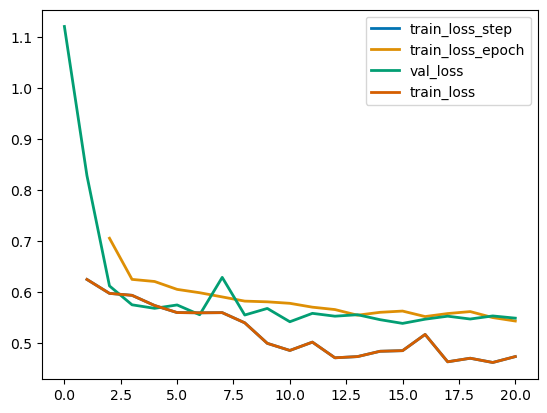

In [8]:
for key, arr in LCU.metric_arrays.items():
    plt.plot(np.arange(len(arr)), arr, linewidth=2, label=key)
plt.legend()

In [86]:
# dir_test_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images'
# dir_test_mask_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022_detailed/'
dir_test_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/',
                            '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/']
dir_test_mask_patches = None
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'
# path_mapping_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__D_subclasses_only__2023-03-10-1154.pkl'
path_mapping_dict='/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories_F3inDE_noFGH__2023-03-17-0957.pkl'
            

# with open('../content/evaluation_sample_50tiles/train_test_split_80tiles_2023-03-22-2131.pkl', 'rb') as f:
with open('../content/evaluation_sample_50tiles/train_test_split_80tiles_2023-03-21-1600.pkl', 'rb') as f:
            dict_tile_patches = pickle.load(f)
            tile_patch_train = dict_tile_patches['train']
            tile_patch_test = dict_tile_patches['test']

test_ds = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=dir_test_mask_patches, 
                            mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                            preprocessing_func=LCU.preprocessing_func, 
                            shuffle_order_patches=True, relabel_masks=True,
                            subsample_patches=False,
                            list_tile_patches_use=tile_patch_test,
                            path_mapping_dict=path_mapping_dict)
test_ds.remove_no_class_patches()
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10, num_workers=8)

Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 285).
Patches ordered randomly
Loaded 284 patches
Loaded label_mapping_dict__main_categories_F3inDE_noFGH__2023-03-17-0957.pkl to map labels


100%|██████████| 284/284 [00:00<00:00, 462.18it/s]

Removed 0 patches with no class


In [37]:
LCU.logger.version

70

In [28]:
cp_path = '/home/tplas//models/lightning_logs/version_69/checkpoints/early_stop_checkpoint-epoch=56-val_loss=0.54.ckpt'
LCU.load_from_checkpoint(cp_path)

focal_loss loss is used.


Instance LCU (not saved) of LandCoverUNet class

In [19]:
trainer = pl.Trainer(max_epochs=1, accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.test(model=LCU, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_ce_loss          0.8466074466705322
     test_dice_loss         0.8794643878936768
     test_focal_loss        0.5514907836914062
      test_iou_loss         0.8801759481430054
        test_loss           0.5514907836914062
  test_overall_accuracy     0.8971876819059694
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5514907836914062,
  'test_ce_loss': 0.8466074466705322,
  'test_focal_loss': 0.5514907836914062,
  'test_iou_loss': 0.8801759481430054,
  'test_dice_loss': 0.8794643878936768,
  'test_overall_accuracy': 0.8971876819059694}]

In [29]:
## Patches of eval data set:
dir_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/',
                  '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/']

## Training data:
with open('../content/evaluation_sample_50tiles/train_test_split_80tiles_2023-03-22-2131.pkl', 'rb') as f:
    dict_tile_patches = pickle.load(f)
    tile_patch_train = dict_tile_patches['train']
    tile_patch_test = dict_tile_patches['test']

# Create DS with just 1 set of masks:
test_ds = lcm.DataSetPatches(im_dir=dir_im_patches, mask_dir=None, 
                            mask_suffix='_lc_2022_detailed_mask.npy',
                            list_tile_patches_use=tile_patch_test,
                            mask_dir_name='masks_detailed_annotation',
                            preprocessing_func=LCU.preprocessing_func, 
                            path_mapping_dict=LCU.dict_training_details['path_mapping_dict'],
                            shuffle_order_patches=False, relabel_masks=True,
                            subsample_patches=False, frac_subsample=.2)
test_ds.remove_no_class_patches()
## Create DS with 2 sets of masks:
# test_ds = lcm.DataSetPatchesTwoMasks(im_dir=dir_im_patches, mask_dir=dir_mask_patches, 
#                             mask_suffix='_lc_80s_mask.npy',
#                             mask_dir_2=dir_mask_patches_2,
#                             mask_suffix_2='_lc_2022_mask.npy',
#                             preprocessing_func=LCU.preprocessing_func, path_mapping_dict=path_mapping_dict,
#                             shuffle_order_patches=True, relabel_masks=True,
#                             subsample_patches=False, frac_subsample=1)

assert test_ds.n_classes == LCU.dict_training_details['n_classes']
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, num_workers=16)

LCU.test_confusion_mat = np.zeros((LCU.n_classes, LCU.n_classes), dtype=np.int32)
trainer = pl.Trainer(max_epochs=1, accelerator='gpu', devices=1)#, auto_lr_find='lr')  # run on GPU; and set max_epochs.


Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__D_subclasses_only__2023-03-10-1154.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 466.95it/s]

Removed 172 patches with no class



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
LCU = lcm.load_model(filename='LCU_2023-03-26-1753.data')

Loaded LCU_2023-03-26-1753
loss_function is focal_loss
n_max_epochs is 60
LandCoverUNet class using FocalLoss_2()
D_subclasses_only training using randomly split eval patch data. focal_loss resnet50 60 epochs


In [38]:
tmp  = trainer.test(model=LCU, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_ce_loss          2.2459163665771484
     test_focal_loss         2.06109356880188
        test_loss            2.06109356880188
  test_overall_accuracy     0.5628072619310843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [37]:
LCU.metric_arrays['val_loss']

array([2.57186604, 2.26917219, 2.2457664 , 2.17782903, 2.13693571,
       2.12291646, 2.15686512, 2.15653753, 2.11939812, 2.09015584,
       2.12818241, 2.12156606, 2.12897062, 2.09335279, 2.14765239,
       2.13186908, 2.0713799 , 2.12909532, 2.08035874, 2.13504457,
       2.10096431, 2.07134795, 2.128546  , 2.09199095, 2.08468747,
       2.11097503, 2.10930753, 2.07352686, 2.06156731, 2.07209921,
       2.10133505, 2.07107615, 2.05949211, 2.06692028, 2.07290053,
       2.10191536, 2.06496859, 2.13411021, 2.06121016, 2.11826444,
       2.06004047, 2.08200979, 2.05794811, 2.06355977, 2.09731078,
       2.10497022, 2.0601027 , 2.05459261, 2.08489752, 2.07900476,
       2.08582211, 2.05780315, 2.071064  , 2.066957  , 2.12396836,
       2.09201026, 2.05790067, 2.06218243, 2.07071662, 2.07170963,
       2.07535696])

In [42]:
tmp[0]

{'test_loss': 1.3320457935333252,
 'test_ce_loss': 1.332045555114746,
 'test_focal_loss': 1.1242464780807495,
 'test_overall_accuracy': 0.9666594101050923}

In [ ]:
model_names = [x for x in os.listdir('/home/tplas/models') if x[-5:] == '.data']#  and x.split('-')[2] in ['26']]  # 21 22
model_names.sort()
print(f'Loaded {len(model_names)} models')

dir_im_patches='/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/images_detailed_annotation/'
## Training data:
with open('../content/evaluation_sample_50tiles/train_test_split_80tiles_2023-03-22-2131.pkl', 'rb') as f:
    dict_tile_patches = pickle.load(f)
    tile_patch_train = dict_tile_patches['train']
    tile_patch_test = dict_tile_patches['test']

def get_best_model(model, best_train_or_val='val'):
    v_num = model.v_num 
    basepath = '/home/tplas/models/lightning_logs/version_' + str(v_num) + '/checkpoints/'
    list_checkpoints = os.listdir(basepath)
    if len(list_checkpoints) == 1:
        cp_path = basepath + list_checkpoints[0]
    elif len(list_checkpoints) == 2:
        list_checkpoints = [x for x in list_checkpoints if x.split('-')[0] == f'best_checkpoint_{best_train_or_val}']
        assert len(list_checkpoints) == 1
        cp_path = basepath + list_checkpoints[0]
    model = model.load_from_checkpoint(cp_path)
    model.first_class_is_no_class = True
    model.eval()
    print(model)
    return model

list_name = [] 
list_backbone = []
list_loss = []
dict_list_best_acc = {'train': [], 'val': []}
list_acc = []   
list_dict_mapping = []
list_epochs = []
for model_id, model_name in enumerate(model_names):
    for i_m, best_method in enumerate(['train', 'val']): 
        LCU = lcm.load_model(filename=model_names[model_id], verbose=0) # reloading necessary for each checkpoint load because checkpoints miss meta info 
        LCU.eval()
        if i_m == 0:  # on first iteration, get saved accuracy (which corresponds to the last epoch)
            acc = LCU.test_confusion_mat[1:, 1:].diagonal().sum() / LCU.test_confusion_mat[1:, 1:].sum()

            list_name.append(model_name)
            list_backbone.append(LCU.description.split(' ')[-3])
            list_loss.append(LCU.dict_training_details['loss_function'])
            list_dict_mapping.append(LCU.dict_training_details['path_mapping_dict'].split('/')[-1].split('__')[1])
            list_acc.append(acc)

        # Create DS with just 1 set of masks:
        test_ds = lcm.DataSetPatches(im_dir=dir_im_patches, mask_dir=None, 
                                    mask_suffix='_lc_2022_detailed_mask.npy',
                                    list_tile_patches_use=tile_patch_test,
                                    mask_dir_name='masks_detailed_annotation',
                                    preprocessing_func=LCU.preprocessing_func, 
                                    path_mapping_dict=LCU.dict_training_details['path_mapping_dict'],
                                    shuffle_order_patches=False, relabel_masks=True,
                                    subsample_patches=False, frac_subsample=.2)
        test_ds.remove_no_class_patches()

        assert test_ds.n_classes == LCU.dict_training_details['n_classes']
        test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, num_workers=16)

        trainer = pl.Trainer(max_epochs=1, accelerator='gpu', devices=1)#, auto_lr_find='lr')  # run on GPU; and set max_epochs.
        LCU = get_best_model(model=LCU, best_train_or_val=best_method)
        LCU.test_confusion_mat = np.zeros((LCU.n_classes, LCU.n_classes), dtype=np.int32)
        tmp  = trainer.test(model=LCU, dataloaders=test_dl)
        dict_list_best_acc[best_method].append(tmp[0]['test_overall_accuracy'])
    
df_info_models = pd.DataFrame({'model_name': list_name, 'backbone': list_backbone, 
                                'loss function': list_loss, 
                                'mean test accuracy (last)': list_acc, 
                                'mean test accuracy (best train)': dict_list_best_acc['train'],
                                'mean test accuracy (best val)': dict_list_best_acc['val'],
                                'dict_mapping': list_dict_mapping})
df_info_models = df_info_models.sort_values(by=['dict_mapping', 'backbone', 'loss function'], ascending=False)
df_info_models = df_info_models.reset_index(drop=True)

In [4]:
df_info_models

,model_name,backbone,loss function,mean test accuracy (last),mean test accuracy (best train),mean test accuracy (best val),dict_mapping
0,LCU_2023-04-24-1114.data,resnet50,focal_loss,0.932955,0.937090,0.939755,main_categories_F3inDE_noFGH
1,LCU_2023-04-25-1644.data,resnet50,focal_loss,0.914435,0.926858,0.931782,main_categories_F3inDE_noFGH
2,LCU_2023-04-25-2018.data,resnet50,focal_loss,0.912536,0.907387,0.930058,main_categories_F3inDE_noFGH
3,LCU_2023-04-26-1209.data,resnet50,focal_loss,0.917460,0.920621,0.931689,main_categories_F3inDE_noFGH
4,LCU_2023-04-26-1837.data,resnet50,focal_loss,0.896402,0.921172,0.929328,main_categories_F3inDE_noFGH
5,LCU_2023-04-21-1502.data,resnet50,cross_entropy,0.922021,0.922159,0.929171,main_categories_F3inDE_noFGH
6,LCU_2023-04-24-1259.data,resnet50,cross_entropy,0.938536,0.951995,0.951995,main_categories_F3inDE_noFGH
7,LCU_2023-04-25-1831.data,resnet50,cross_entropy,0.922086,0.906495,0.922729,main_categories_F3inDE_noFGH
8,LCU_2023-04-25-2204.data,resnet50,cross_entropy,0.901618,0.925613,0.933891,main_categories_F3inDE_noFGH
9,LCU_2023-04-26-1353.data,resnet50,cross_entropy,0.929521,0.929481,0.935035,main_categories_F3inDE_noFGH


In [5]:
df_mean_models = df_info_models.groupby(['dict_mapping', 'backbone', 'loss function']).agg({'mean test accuracy (best train)': ['mean', 'std', 'max'],
                                                                                            'mean test accuracy (best val)': ['mean', 'std', 'max']})#.drop(columns=['mean accuracy'])
df_mean_models.round(2)

mean test accuracy (best train)  \
                                                                               mean   
dict_mapping                 backbone loss function                                   
C_subclasses_only            resnet50 cross_entropy                            0.90   
                                      focal_loss                               0.87   
D_subclasses_only            resnet50 cross_entropy                            0.67   
                                      focal_loss                               0.70   
E_subclasses_and_F3d_only    resnet50 cross_entropy                            0.85   
                                      focal_loss                               0.83   
all_relevant_subclasses      resnet50 cross_entropy                            0.67   
main_categories_F3inDE_noFGH resnet50 cross_entropy                            0.93   
                                      focal_loss                               0.92   

                                                                 \
                                                      std   max   
dict_mapping                 backbone loss function               
C_subclasses_only            resnet50 cross_entropy  0.01  0.92   
                                      focal_loss     0.10  0.93   
D_subclasses_only            resnet50 cross_entropy  0.03  0.72   
                                      focal_loss     0.02  0.72   
E_subclasses_and_F3d_only    resnet50 cross_entropy  0.02  0.87   
                                      focal_loss     0.02  0.84   
all_relevant_subclasses      resnet50 cross_entropy  0.04  0.71   
main_categories_F3inDE_noFGH resnet50 cross_entropy  0.02  0.95   
                                      focal_loss     0.01  0.94   

                                                    mean test accuracy (best val)  \
                                                                             mean   
dict_mapping                 backbone loss function                                 
C_subclasses_only            resnet50 cross_entropy                          0.92   
                                      focal_loss                             0.93   
D_subclasses_only            resnet50 cross_entropy                          0.71   
                                      focal_loss                             0.73   
E_subclasses_and_F3d_only    resnet50 cross_entropy                          0.86   
                                      focal_loss                             0.86   
all_relevant_subclasses      resnet50 cross_entropy                          0.69   
main_categories_F3inDE_noFGH resnet50 cross_entropy                          0.93   
                                      focal_loss                             0.93   

                                                                 
                                                      std   max  
dict_mapping                 backbone loss function              
C_subclasses_only            resnet50 cross_entropy  0.02  0.94  
                                      focal_loss     0.02  0.96  
D_subclasses_only            resnet50 cross_entropy  0.02  0.72  
                                      focal_loss     0.03  0.76  
E_subclasses_and_F3d_only    resnet50 cross_entropy  0.01  0.87  
                                      focal_loss     0.01  0.88  
all_relevant_subclasses      resnet50 cross_entropy  0.04  0.71  
main_categories_F3inDE_noFGH resnet50 cross_entropy  0.01  0.95  
                                      focal_loss     0.00  0.94

In [6]:
df_mean_models = df_info_models.groupby(['dict_mapping', 'backbone', 'loss function']).agg({'mean test accuracy (best train)': ['mean', 'std', 'max']})#.drop(columns=['mean accuracy'])
df_mean_models = df_mean_models.round(2)
## drop column backbone
# df_mean_models.columns = df_mean_models.drop(columns=['backbone'])
df_mean_models

mean test accuracy (best train)  \
                                                                               mean   
dict_mapping                 backbone loss function                                   
C_subclasses_only            resnet50 cross_entropy                            0.90   
                                      focal_loss                               0.87   
D_subclasses_only            resnet50 cross_entropy                            0.67   
                                      focal_loss                               0.70   
E_subclasses_and_F3d_only    resnet50 cross_entropy                            0.85   
                                      focal_loss                               0.83   
all_relevant_subclasses      resnet50 cross_entropy                            0.67   
main_categories_F3inDE_noFGH resnet50 cross_entropy                            0.93   
                                      focal_loss                               0.92   

                                                                 
                                                      std   max  
dict_mapping                 backbone loss function              
C_subclasses_only            resnet50 cross_entropy  0.01  0.92  
                                      focal_loss     0.10  0.93  
D_subclasses_only            resnet50 cross_entropy  0.03  0.72  
                                      focal_loss     0.02  0.72  
E_subclasses_and_F3d_only    resnet50 cross_entropy  0.02  0.87  
                                      focal_loss     0.02  0.84  
all_relevant_subclasses      resnet50 cross_entropy  0.04  0.71  
main_categories_F3inDE_noFGH resnet50 cross_entropy  0.02  0.95  
                                      focal_loss     0.01  0.94

In [7]:
## For each combination of backbone, loss function, dict_mapping, get the corresponding model_name with the highest mean best accuracy:
df_best_models = df_info_models.groupby(['dict_mapping', 'backbone', 'loss function']).agg({'mean test accuracy (best train)': ['max']}).reset_index()
df_best_models = df_best_models.droplevel(1, 1)
df_best_models = df_best_models.merge(df_info_models, on=['dict_mapping', 'backbone', 'loss function', 'mean test accuracy (best train)'])#.drop(columns=['mean accuracy'])
df_best_models

,dict_mapping,backbone,loss function,mean test accuracy (best train),model_name,mean test accuracy (last),mean test accuracy (best val)
0,C_subclasses_only,resnet50,cross_entropy,0.915980,LCU_2023-04-21-1335.data,0.842505,0.944091
1,C_subclasses_only,resnet50,focal_loss,0.928159,LCU_2023-04-21-1520.data,0.888573,0.928193
2,D_subclasses_only,resnet50,cross_entropy,0.722403,LCU_2023-04-25-2057.data,0.706950,0.720986
3,D_subclasses_only,resnet50,focal_loss,0.719454,LCU_2023-04-25-2243.data,0.715008,0.764939
4,E_subclasses_and_F3d_only,resnet50,cross_entropy,0.865554,LCU_2023-04-24-1216.data,0.850118,0.868631
5,E_subclasses_and_F3d_only,resnet50,focal_loss,0.843328,LCU_2023-04-21-1604.data,0.852135,0.880641
6,all_relevant_subclasses,resnet50,cross_entropy,0.713649,LCU_2023-05-12-1015.data,0.699327,0.713649
7,main_categories_F3inDE_noFGH,resnet50,cross_entropy,0.951995,LCU_2023-04-24-1259.data,0.938536,0.951995
8,main_categories_F3inDE_noFGH,resnet50,focal_loss,0.937090,LCU_2023-04-24-1114.data,0.932955,0.939755


Removing NO CLASS from confusion matrix


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


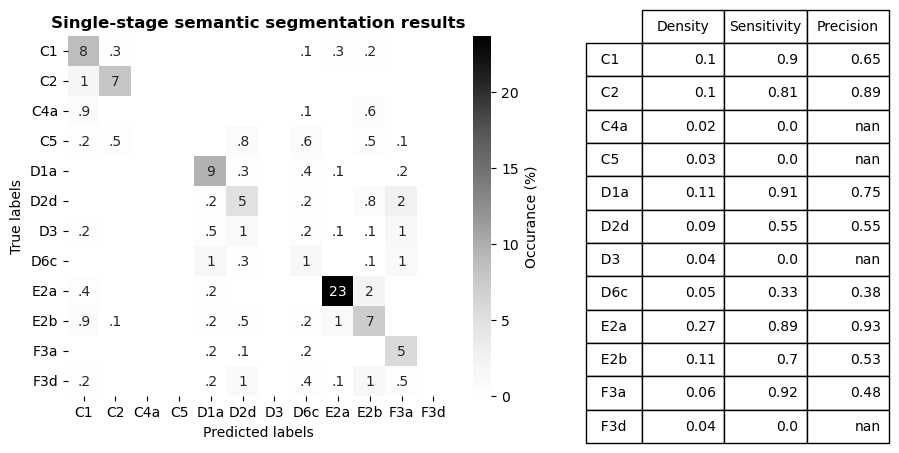

In [3]:
model_name = 'LCU_2023-05-12-1015.data'
save_fig = False 

LCU = lcm.load_model(filename=model_name, verbose=0) # reloading necessary for each checkpoint load because checkpoints miss meta info

tmp = lcv.plot_confusion_summary(model=LCU, conf_mat=None, class_name_list=LCU.dict_training_details['class_name_list'],
                           normalise_hm=True, skip_factor=1, fmt_annot='.1f',
                           print_main_text=False, suppress_zero_annot=True,
                           remove_no_class_if_present=True,
                           class_indices_to_remove=[9],
                           title_hm='Single-stage semantic segmentation results')

if save_fig:
    plt.savefig('/home/tplas/repos/cnn-land-cover/figures/fig_conf_mat_singlestage.pdf', dpi=300, bbox_inches='tight')

In [22]:
df_mean_models_latex = df_mean_models.droplevel(0, axis=1).reset_index()
## drop column backbone
df_mean_models_latex = df_mean_models_latex.drop(columns=['backbone'])  # not needed with only 
df_mean_models_latex['Selected?'] = '-'
df_mean_models_latex = df_mean_models_latex.rename(columns={'dict_mapping': 'Classifier'})
df_mean_models_latex['loss function'] = df_mean_models_latex['loss function'].map({'cross_entropy': 'Cross entropy', 'focal_loss': 'Focal loss'})
df_mean_models_latex['Classifier'] = df_mean_models_latex['Classifier'].apply(lambda x: x.split('_')[0]).apply(lambda x: x[0].upper() + x[1:] if len(x) > 1 else x.upper())
df_mean_models_latex['Classifier'] = df_mean_models_latex['Classifier'].str.replace('All', 'Single-stage')
# df_mean_models_latex.columns
lca.export_df_stats_to_latex(df_mean_models_latex, cols_2_decimals=[],#'Mean', 'Std', 'Max'],
                             cols_1_decimal_perc=[], path_latex='../figures/tables/df_mean_stats_models.tex')


Index(['Classifier', 'loss function', 'mean', 'std', 'max', 'Selected?'], dtype='object')


,\textbf{Classifier},\textbf{Loss function},\textbf{Mean},\textbf{Std},\textbf{Max},\textbf{Selected?}
0,C,Cross entropy,0.90,0.01,0.92,-
1,C,Focal loss,0.87,0.10,0.93,-
2,D,Cross entropy,0.67,0.03,0.72,-
3,D,Focal loss,0.70,0.02,0.72,-
4,E,Cross entropy,0.85,0.02,0.87,-
5,E,Focal loss,0.83,0.02,0.84,-
6,Single-stage,Cross entropy,0.67,0.04,0.71,-
7,Main,Cross entropy,0.93,0.02,0.95,-
8,Main,Focal loss,0.92,0.01,0.94,-


In [4]:
# model_id +=1 
# model_id = 9 + 5
# print(model_id)
LCU = lcm.load_model(filename='LCU_2023-03-25-2206.data')
LCU.eval()
print(LCU.v_num)
# LCU = LCU.load_from_checkpoint('/home/tplas/models/lightning_logs/version_128/checkpoints/best_checkpoint-epoch=27-val_loss=1.05.ckpt')
# acc = LCU.test_confusion_mat[1:, 1:].diagonal().sum() / LCU.test_confusion_mat[1:, 1:].sum()
# print(acc)
# _ = lcv.plot_confusion_summary(LCU, normalise_hm=True, fmt_annot='.1f', text_under_mat=True,
#                                suppress_zero_annot=True)

Loaded LCU_2023-03-25-2206
loss_function is cross_entropy
n_max_epochs is 20
LandCoverUNet class using CrossEntropyLoss()
E_subclasses_and_F3d_only training using randomly split eval patch data. cross_entropy resnet50 90 epochs
132


In [5]:
LCU.metric_arrays['val_loss'], LCU.first_class_is_no_class

(array([1.62600207, 1.33081257, 1.14857328, 1.15204978, 1.10413945,
        1.11631489, 1.15380585, 1.09188616, 1.08460367, 1.10390198,
        1.0945698 , 1.19003272, 1.08901656, 1.10231733, 1.07958603,
        1.14581573, 1.05779135, 1.08473468, 1.08920693, 1.04948425,
        1.07366264]),
 True)

In [15]:
# LCU.v_num
## load checkpoint
cp_path = '/home/tplas//models/lightning_logs/version_132/checkpoints/best_checkpoint-epoch=18-val_loss=1.05.ckpt'
LCU = LCU.load_from_checkpoint(cp_path)


cross_entropy loss is used.


In [14]:
# LCU.first_class_is_no_class
test_ds.class_name_list[0] in ['NO CLASS', '0']

True

In [16]:
LCU.first_class_is_no_class# = True

False

In [19]:
# test_ds.df_patches
LCU.reset_test_confusion_mat()
trainer = pl.Trainer(max_epochs=1, accelerator='gpu', devices=1)
trainer.test(model=LCU, dataloaders=test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_ce_loss          1.0503242015838623
     test_focal_loss         0.787542998790741
        test_loss           1.0503242015838623
  test_overall_accuracy     0.6306827742019017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0503242015838623,
  'test_ce_loss': 1.0503242015838623,
  'test_focal_loss': 0.787542998790741,
  'test_overall_accuracy': 0.6306827742019017}]

In [6]:
## Patches of eval data set:
dir_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/',
                  '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/']

## Training data:
with open('../content/evaluation_sample_50tiles/train_test_split_80tiles_2023-03-22-2131.pkl', 'rb') as f:
    dict_tile_patches = pickle.load(f)
    tile_patch_train = dict_tile_patches['train']
    tile_patch_test = dict_tile_patches['test']

# Create DS with just 1 set of masks:
test_ds = lcm.DataSetPatches(im_dir=dir_im_patches, mask_dir=None, 
                            mask_suffix='_lc_2022_detailed_mask.npy',
                            list_tile_patches_use=tile_patch_test,
                            mask_dir_name='masks_detailed_annotation',
                            preprocessing_func=LCU.preprocessing_func, 
                            path_mapping_dict=LCU.dict_training_details['path_mapping_dict'],
                            shuffle_order_patches=False, relabel_masks=True,
                            subsample_patches=False, frac_subsample=.2)
test_ds.remove_no_class_patches()
## Create DS with 2 sets of masks:
# test_ds = lcm.DataSetPatchesTwoMasks(im_dir=dir_im_patches, mask_dir=dir_mask_patches, 
#                             mask_suffix='_lc_80s_mask.npy',
#                             mask_dir_2=dir_mask_patches_2,
#                             mask_suffix_2='_lc_2022_mask.npy',
#                             preprocessing_func=LCU.preprocessing_func, path_mapping_dict=path_mapping_dict,
#                             shuffle_order_patches=True, relabel_masks=True,
#                             subsample_patches=False, frac_subsample=1)

assert test_ds.n_classes == LCU.dict_training_details['n_classes']
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, num_workers=16)

# LCU.test_confusion_mat = np.zeros((LCU.n_classes, LCU.n_classes), dtype=np.int32)
# trainer = pl.Trainer(max_epochs=1, accelerator='gpu', devices=1)#, auto_lr_find='lr')  # run on GPU; and set max_epochs.
# trainer.test(model=LCU, dataloaders=test_dl)

Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__E_subclasses_and_F3d_only__2023-03-15-1323.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 401.02it/s]

Removed 150 patches with no class


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_ce_loss          0.8260069489479065
     test_dice_loss          0.909199595451355
     test_focal_loss        0.5309705138206482
      test_iou_loss          0.878243088722229
        test_loss           0.8260069489479065
  test_overall_accuracy     0.9202479568468721
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8260069489479065,
  'test_ce_loss': 0.8260069489479065,
  'test_focal_loss': 0.5309705138206482,
  'test_iou_loss': 0.878243088722229,
  'test_dice_loss': 0.909199595451355,
  'test_overall_accuracy': 0.9202479568468721}]

In [88]:
test_ds.df_patches[test_ds.df_patches['tile_name'] == 'SK0366']

,patch_name,tile_name,im_filepath,mask_filepath
34,SK0366_patch132,SK0366,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
69,SK0366_patch013,SK0366,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
70,SK0366_patch017,SK0366,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...
152,SK0366_patch160,SK0366,/home/tplas/data/gis/most recent APGB 12.5cm a...,/home/tplas/data/gis/most recent APGB 12.5cm a...


In [59]:
LCU.logger.versionSK1357

69

(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
69


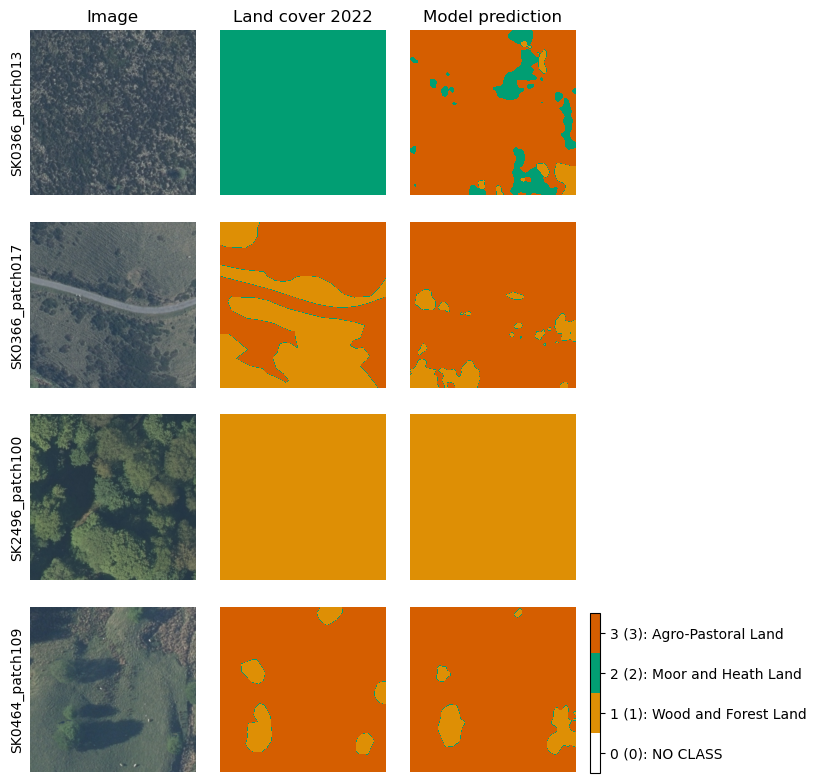

In [90]:
# kk += 4
kk = 69
tmp_batch, names_patches = lcm.get_batch_from_ds(ds=test_ds, 
                                                 batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU, batch=tmp_batch,
                                        #  test_dl=test_dl, 
                                         preprocessing_fun=test_ds.preprocessing_func,
                                         lc_class_name_list=test_ds.class_name_list, 
                                         unique_labels_array=test_ds.unique_labels_arr,
                                         names_patches=names_patches)
print(kk)

In [4]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # run on GPU; and set max_epochs.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [88]:
LCU.test_confusion_mat.sum() / 64e6

46.08

In [50]:
LCU.skip_factor_eval = 4

In [51]:
trainer.test(LCU, dataloaders=test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_ce_loss          1.3150688409805298
     test_focal_loss        1.0253939628601074
      test_iou_loss         0.9579325914382935
        test_loss           1.0253939628601074
  test_overall_accuracy     0.8515828671373136
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0253939628601074,
  'test_ce_loss': 1.3150688409805298,
  'test_focal_loss': 1.0253939628601074,
  'test_iou_loss': 0.9579325914382935,
  'test_overall_accuracy': 0.8515828671373136}]

## Predict full tiles:

In [3]:
tile_path = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/117574-1_RGB_1_Shape/SK0366.tif'

In [6]:
mask_tile, mask_shp = lcm.prediction_one_tile(model=LCU, tilepath=tile_path, 
                                              create_shp=True, save_shp=False, model_name='LCU_2022-11-30-1205')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Divided tile
Predicting patches:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Now creating polygons of prediction


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
mask_shp = gpd.read_file('/home/tplas/tmp_filter_pred/original_predictions_SK0366/original_predictions_SK0366.shp')
# mask_shp = gpd.read_file('/home/tplas/predictions_LCU_2022-11-30-1205/LCU_2022-11-30-1205_SK1798_LC-prediction/LCU_2022-11-30-1205_SK1798_LC-prediction.shp')

In [22]:
tmp = lca.filter_small_polygons_from_gdf(gdf=mask_shp, area_threshold=500000)

Current iteration: 0/5
Number of pols smaller than 500000: 6823/6823
No pols greater than area threshold. Converting all small pols to no-class


Text(0, 0.5, 'mean accuracy')

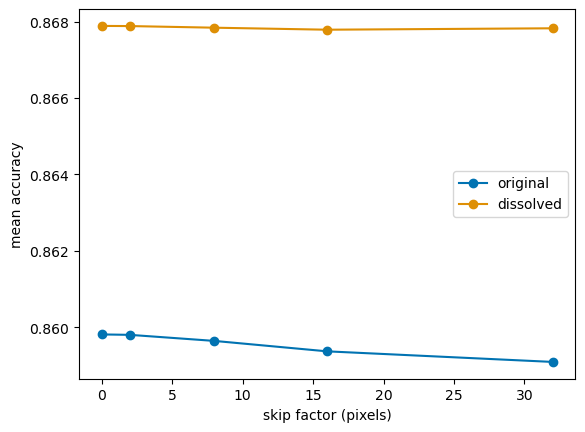

In [20]:
# dict_skip_factor_infl_orig = {} 

# sf_arr = [0, 2, 8, 16, 32]

# for sf in sf_arr:
#     dict_skip_factor_infl_orig[sf] = lca.compute_confusion_mat_from_dirs(dir_mask_true='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022',
#                                             dir_mask_pred_shp='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_predicted/predictions_LCU_2022-11-30-1205/',
#                                             lc_class_name_list=LCU.dict_training_details['class_name_list'],
#                                             unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])),
#                                             skip_factor=sf)
# dict_skip_factor_infl_total = {'orig': dict_skip_factor_infl_orig,
#                                 'filtered': dict_skip_factor_infl}

# with open('/home/tplas/dict_skip_factor_sweep.pkl', 'wb') as f:
#     pickle.dump(dict_skip_factor_infl_total, f)

with open('/home/tplas/dict_skip_factor_sweep.pkl', 'rb') as f:
    dict_skip_factor_infl = pickle.load(f)
# dict_skip_factor_infl

dict_sf_arr = {}
dict_acc_arr = {}
for key_dissolv, dict_sf in dict_skip_factor_infl.items():
    dict_sf_arr[key_dissolv] = np.zeros(len(dict_sf))
    dict_acc_arr[key_dissolv] = np.zeros(len(dict_sf))
    for i_sf, (key_sf, stats) in enumerate(dict_sf.items()):
        dict_sf_arr[key_dissolv][i_sf] = key_sf
        dict_acc_arr[key_dissolv][i_sf] = np.mean(list(stats[0].values()))


    plt.plot(dict_sf_arr[key_dissolv], dict_acc_arr[key_dissolv], 'o-', 
             label='dissolved' if key_dissolv == 'filtered' else 'original')
plt.legend()
plt.xlabel('skip factor (pixels)')
plt.ylabel('mean accuracy')

In [10]:


# stats_80s_vs_2022 = lca.compute_confusion_mat_from_dirs(dir_mask_true='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022',
#                                             # dir_mask_pred_shp='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_predicted/predictions_LCU_2022-11-30-1205/',
#                                             dir_mask_pred_tif='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_80s/',
#                                             path_mapping_pred_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl',
#                                             lc_class_name_list=LCU.dict_training_details['class_name_list'],
#                                             unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])),
#                                             skip_factor=None)
                                            


# stats_pred_vs_2022 = lca.compute_confusion_mat_from_dirs(dir_mask_true='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022',
#                                             dir_mask_pred_shp='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_predicted/predictions_LCU_2022-11-30-1205/',
#                                             # dir_mask_pred_tif='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_80s/',
#                                             # path_mapping_pred_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl',
#                                             lc_class_name_list=LCU.dict_training_details['class_name_list'],
#                                             unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])),
#                                             skip_factor=None)
                                            
                                        

stats_pred_vs_2022_dissolved = lca.compute_confusion_mat_from_dirs(dir_mask_true='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022_FGH-override',
                                            # dir_mask_pred_shp='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_predicted/predictions_LCU_2022-11-30-1205_dissolved_1000m2/',
                                            dir_mask_pred_shp='/home/tplas/predictions/predictions_LCU_2023-01-23-2018_dissolved1000m2_padding44_FGH-override',
                                            # dir_mask_pred_tif='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_80s/',
                                            # path_mapping_pred_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl',
                                            lc_class_name_list=LCU.dict_training_details['class_name_list'],
                                            unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])),
                                            skip_factor=16, padding=44)
                                            


Loading predicted mask shp files
Found 50 predicted mask shp files


50it [02:52,  3.45s/it]


In [6]:
pad_list = [14, 44, 72, 96]

stats_dict = {}
for pad in pad_list:
    stats_dict[pad] = lca.compute_confusion_mat_from_dirs(dir_mask_true='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022_FGH-override',
                                            # dir_mask_pred_shp='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_predicted/predictions_LCU_2022-11-30-1205_dissolved_1000m2/',
                                            dir_mask_pred_shp=f'/home/tplas/predictions/predictions_LCU_2023-01-23-2018_dissolved1000m2_padding{pad}_FGH-override',
                                            # dir_mask_pred_tif='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_80s/',
                                            # path_mapping_pred_dict = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__main_categories__2022-11-17-1512.pkl',
                                            lc_class_name_list=LCU.dict_training_details['class_name_list'],
                                            unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])),
                                            skip_factor=16, padding=pad)
                                            

Loading predicted mask shp files
Found 50 predicted mask shp files


50it [02:57,  3.54s/it]


Loading predicted mask shp files
Found 50 predicted mask shp files


50it [03:08,  3.78s/it]


Loading predicted mask shp files
Found 50 predicted mask shp files


50it [02:51,  3.42s/it]


Loading predicted mask shp files
Found 50 predicted mask shp files


50it [02:51,  3.42s/it]


Text(0, 0.5, 'mean accuracy')

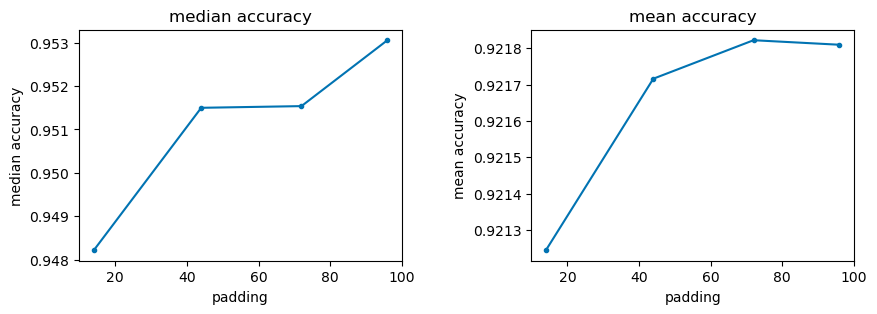

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace': 0.4})


ax[0].plot(pad_list, [np.median(list(stats_dict[x][0].values())) for x in pad_list], '.-')
ax[0].set_title('median accuracy')
ax[0].set_xlabel('padding')
ax[0].set_ylabel('median accuracy')

ax[1].plot(pad_list, [np.mean(list(stats_dict[x][0].values())) for x in pad_list], '.-')
ax[1].set_title('mean accuracy')
ax[1].set_xlabel('padding')
ax[1].set_ylabel('mean accuracy')

In [30]:
stats_pred_vs_2022_dissolved = stats_dict[44]

In [11]:
lca.get_padding_edges_from_sizes(padding=96)

(48, 7952)

SK0366: 0.5857566813438493
SK2055: 0.7370405316043289
SK1357: 0.6704085417977129


Text(0.01, 0.8, 'median accuracy: 0.951')

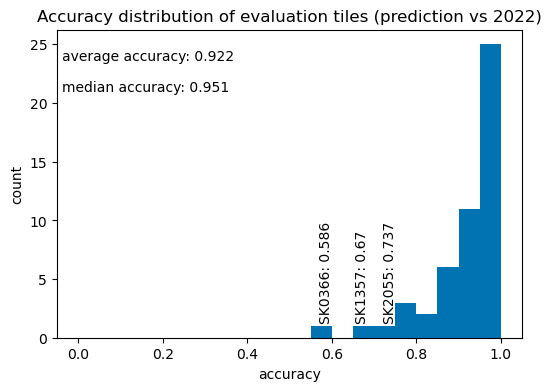

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
accuracy_dict = stats_pred_vs_2022_dissolved[0]
acc_arr = np.array(list(accuracy_dict.values()))
ax.hist(acc_arr, bins=np.linspace(0, 1, 21))
ax.set_xlabel('accuracy')
ax.set_ylabel('count')
ax. set_title('Accuracy distribution of evaluation tiles (prediction vs 2022)')
for key, val in accuracy_dict.items():
    if val < 0.75:
        print(f'{key}: {val}')
        ax.annotate(s=f'{key}: {np.round(val, 3)}', xy=(val, 0), xycoords='data', xytext=(0, 10), textcoords='offset points', rotation=90, ha='center', va='bottom')

ax.annotate(s=f'average accuracy: {np.round(np.mean(list(accuracy_dict.values())), 3)}', xy=(0.01, 0.9), xycoords='axes fraction')
ax.annotate(s=f'median accuracy: {np.round(np.median(list(accuracy_dict.values())), 3)}', xy=(0.01, 0.8), xycoords='axes fraction')

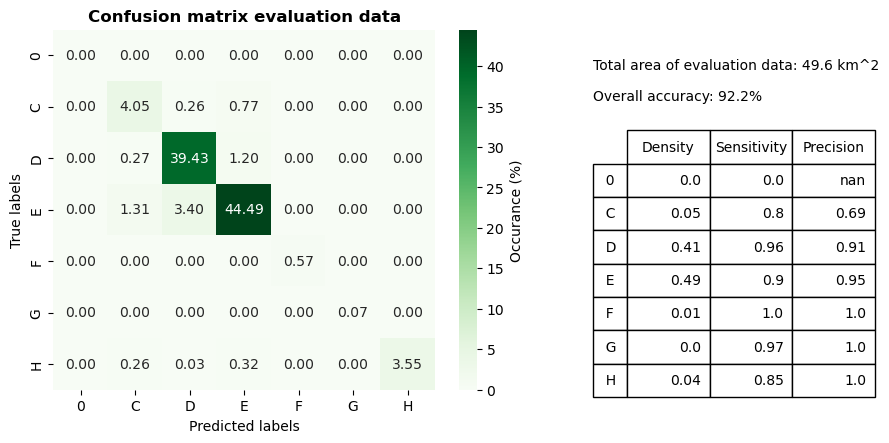

In [32]:
total_conf_mat = np.array(list(stats_pred_vs_2022_dissolved[2].values())).sum(0)

tmp = lcv.plot_confusion_summary(model=None, conf_mat=total_conf_mat, class_name_list=LCU.dict_training_details['class_name_list'],
                           normalise_hm=True, skip_factor=16)
                           
# tmp[3][0].set_title('Confusion matrix 80s vs 2022\n of evaluation tiles', weight='bold')
# tmp[3][0].set_xlabel('LC 80s')
# tmp[3][0].set_ylabel('LC 2022')

In [26]:
lca.merge_individual_shp_files(dir_indiv_tile_shp='/home/tplas/LCU_2023-01-23-2018/dissolved1000m2/')

50it [00:01, 25.72it/s]


,class,Class name,area,polygon_id,geometry
0,0.0,NO CLASS,78400.000000,0.0,"POLYGON ((415960.000 369000.000, 416000.000 36..."
1,1.0,Wood and Forest Land,3609.984375,1.0,"POLYGON ((415755.500 368040.000, 415754.125 36..."
2,1.0,Wood and Forest Land,20296.437500,2.0,"POLYGON ((415870.000 368230.500, 415870.125 36..."
3,1.0,Wood and Forest Land,1731.546875,3.0,"POLYGON ((415488.500 368482.875, 415488.500 36..."
4,2.0,Moor and Heath Land,9257.328125,4.0,"POLYGON ((415334.500 368167.000, 415334.500 36..."
...,...,...,...,...,...
654,3.0,Agro-Pastoral Land,1533.437500,26.0,"POLYGON ((407814.250 352320.375, 407814.250 35..."
655,3.0,Agro-Pastoral Land,1173.031250,27.0,"POLYGON ((407383.125 352414.250, 407383.125 35..."
656,3.0,Agro-Pastoral Land,751373.140625,28.0,"POLYGON ((407000.000 352074.000, 407000.000 35..."
657,3.0,Agro-Pastoral Land,1802.687500,29.0,"POLYGON ((407054.375 352975.500, 407054.625 35..."


In [26]:
thresh_arr = np.zeros(len(tmp))
av_acc_arr = np.zeros(len(tmp_dict_sel))
ci_acc_arr = np.zeros(len(tmp_dict_sel))
tilename = 'SK0366'

av_acc_arr[i] = np.mean(list(val['dict_acc_tiles'].values()))
# ci_acc_arr[i] = np.std(list(val['dict_acc_tiles'].values())) / np.sqrt(len(val['dict_acc_tiles'].values())) * 1.96
# av_acc_arr[i] = val['dict_acc_tiles'][tilename]
# av_acc_arr[i] = np.mean([np.nanmean(val['dict_df_stats_tiles'][x]['sensitivity']) for x in val['dict_df_stats_tiles'].keys()])
# av_acc_arr[i] = np.nanmean([val['dict_df_stats_tiles'][x]['sensitivity'].iloc[1] for x in val['dict_df_stats_tiles'].keys()])


inds_sorted = np.argsort(thresh_arr)
thresh_arr = thresh_arr[inds_sorted]
av_acc_arr = av_acc_arr[inds_sorted]

plt.plot(thresh_arr, av_acc_arr, 'o-')
# plt.fill_between(thresh_arr, av_acc_arr-ci_acc_arr, av_acc_arr+ci_acc_arr, alpha=0.2)
plt.xlabel('Area threshold [m2]')
# plt.ylabel('Average sensitivity [%]')
plt.ylabel(f'Accuarcy [%] of {tilename}')
plt.xscale('log')
# plt.ylim([0.76, 0.78])

({'SK1871': 0.8553175862630208,
  'SE0800': 0.9018878512912326,
  'SJ9679': 0.9220696004231771,
  'SK0879': 0.8566658528645833,
  'SK1992': 0.9933929782443577,
  'SK0685': 0.9185893927680121,
  'SK2777': 0.0,
  'SK0369': 0.30949940999348957,
  'SE0705': 1.0,
  'SK0464': 0.8763926527235243,
  'SK2055': 0.4123371209038629,
  'SK1472': 0.9458269246419271,
  'SK0456': 0.9092888895670573,
  'SK0752': 0.8471364169650608,
  'SK0896': 1.0,
  'SJ9772': 0.9536248779296875,
  'SK1399': 0.9950452507866754,
  'SK1975': 0.9357431030273438,
  'SK2091': 1.0,
  'SK1357': 0.642309095594618,
  'SK0366': 0.8117153930664063,
  'SK1798': 1.0,
  'SK1896': 1.0,
  'SK1683': 0.7856475999620226,
  'SK1874': 0.8906782362196181,
  'SK0790': 1.0,
  'SK2096': 1.0,
  'SK0988': 1.0,
  'SK1360': 0.8842644415961372,
  'SK2496': 0.8872039116753472,
  'SK2196': 1.0,
  'SK0686': 0.8285010952419705,
  'SK0077': 0.7996869066026475,
  'SK1661': 0.9643880038791233,
  'SK1568': 0.8663031175401475,
  'SK0852': 0.8915238274468316

In [24]:
8000 - (8000 % 512)

7680

In [5]:
# cm = lca.compute_confusion_mat_from_two_masks(mask_true=lca.convert_shp_mask_to_raster(df_shp=mask_shp, col_name='class')['class'], 
#                                          mask_pred=lca.convert_shp_mask_to_raster(df_shp=tmp, col_name='class')['class'], 
#                                          lc_class_name_list=LCU.dict_training_details['class_name_list'],
#                                          unique_labels_array=np.arange(len(LCU.dict_training_details['class_name_list'])))

NameError: name 'mask_shp' is not defined

scripts/land_cover_visualisation.py:614: RuntimeWarning: invalid value encountered in double_scalars
  sub_accuracy = sub_mat.diagonal().sum() / sub_mat.sum()


(              class name class shortcut  sensitivity  precision  true density  \
 0               NO CLASS              0          1.0   0.079176      0.079176   
 1   Wood and Forest Land              C          0.0        NaN      0.065934   
 2    Moor and Heath Land              D          0.0        NaN      0.228548   
 3     Agro-Pastoral Land              E          0.0        NaN      0.626342   
 4      Water and Wetland              F          NaN        NaN      0.000000   
 5  Rock and Coastal Land              G          NaN        NaN      0.000000   
 6         Developed Land              H          NaN        NaN      0.000000   
 
    predicted density  
 0                1.0  
 1                0.0  
 2                0.0  
 3                0.0  
 4                0.0  
 5                0.0  
 6                0.0  ,
 0.07917559432710948,
 nan,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7ffb23b94950>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7ffb30ba6310>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


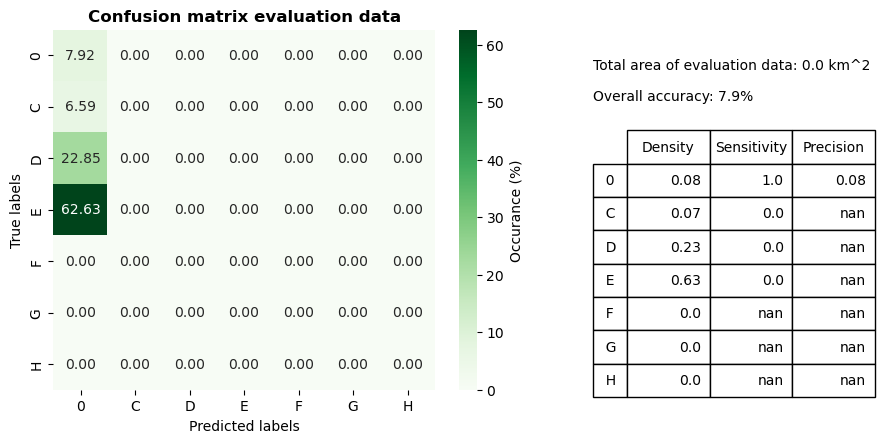

In [35]:
lcv.plot_confusion_summary(conf_mat=cm, class_name_list=LCU.dict_training_details['class_name_list'], normalise_hm=True)

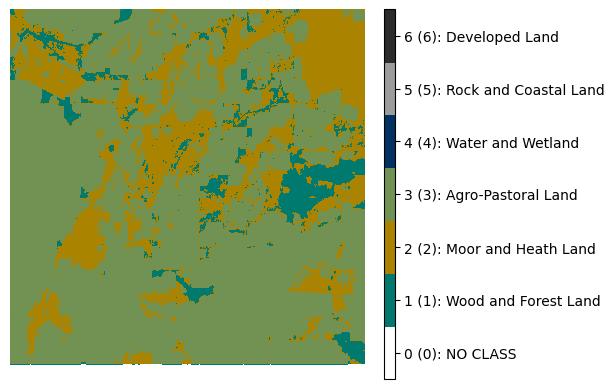

In [120]:
lcv.plot_landcover_image(mask_tile, lc_class_name_list=test_ds.class_name_list, 
                                    unique_labels_array=test_ds.unique_labels_arr)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


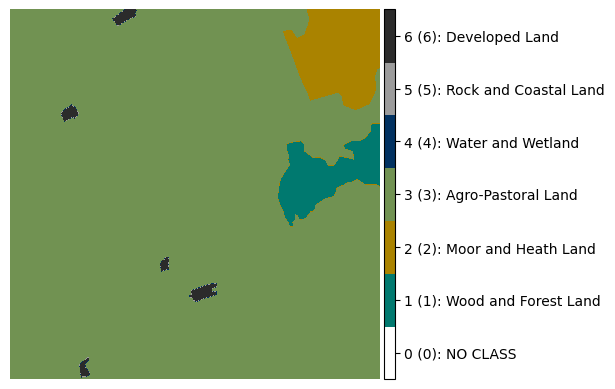

In [7]:
tile_path_mask = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/SK0366_lc_2022_mask.tif'
mask_tile_true = lca.load_tiff(tile_path_mask)

lcv.plot_landcover_image(np.squeeze(mask_tile_true), lc_class_name_list=test_ds.class_name_list, 
                                         unique_labels_array=test_ds.unique_labels_arr)

scripts/land_cover_visualisation.py:596: RuntimeWarning: invalid value encountered in double_scalars
  sens_arr[i_c] = conf_mat[i_c, i_c] / conf_mat[i_c, :].sum()  # sum of true pos + false neg
scripts/land_cover_visualisation.py:597: RuntimeWarning: invalid value encountered in double_scalars
  prec_arr[i_c] = conf_mat[i_c, i_c] / conf_mat[:, i_c].sum()  # sum of true pos + false pos


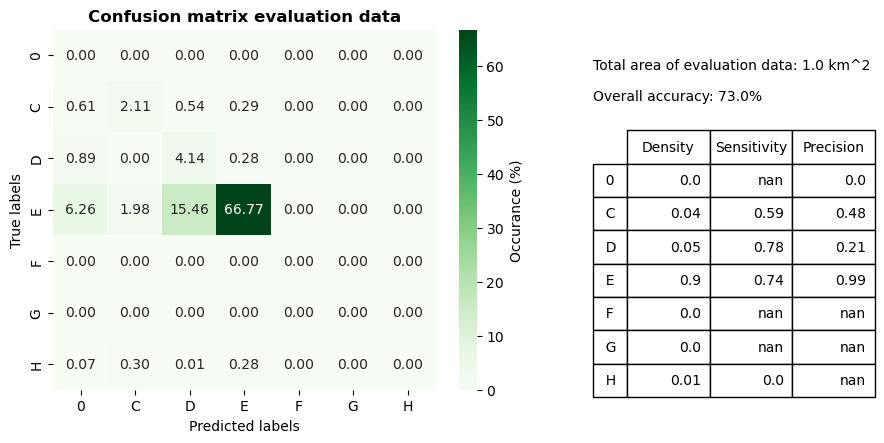

In [28]:
conf_mat = lca.compute_confusion_mat_from_two_masks(mask_true=mask_tile_true, mask_pred=mask_tile, 
                                                    lc_class_name_list=test_ds.class_name_list, 
                                                    unique_labels_array=test_ds.unique_labels_arr)
_ = lcv.plot_confusion_summary(conf_mat=conf_mat, class_name_list=test_ds.class_name_list, normalise_hm=True)

In [7]:
tmp_results = lcm.tile_prediction_wrapper(model=LCU, save_shp=True,
                            dir_im='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/',
                            dir_mask_eval='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/',
                            save_folder='/home/tplas/predictions_LCU_2022-11-30-1205_dissolved1000m2',
                            dissolve_small_pols=True, area_threshold=1000, skip_factor=16)

Loaded 50 tiffs from subdirs of /home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/
Evaluating vs true masks
Dissolving small polygons. WARNING: this takes considerable overhead computinsave_rasterg time


0it [00:00, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
2879it [02:57, 16.22it/s]
scripts/land_cover_analysis.py:1129: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to Fal

In [15]:
## Open previously saved results with pickle:
with open('/home/tplas/LCU_2023-01-23-2018/dissolved1000m2/summary_results.pkl', 'rb') as f:
    tmp_results = pickle.load(f)

In [20]:
tmp_results[2]['SK2777']

array([[     0.,      0.,      0.,      0.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.,      0.,      0.],
       [     0.,      0., 205364.,  25036.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.,      0.,      0.],
       [     0.,      0.,      0.,      0.,      0.,      0.,      0.]])

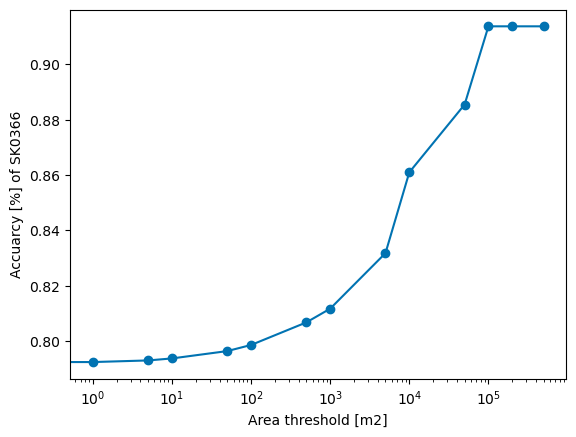

In [61]:
# import logging
# logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# dict_eval_stats = {} 
# threshold_array = [0, 1, 10, 100, 1000, 10000]
# for i, thresh in enumerate(threshold_array):
#     dict_eval_stats[thresh] = {}
#     tmp_results = lcm.tile_prediction_wrapper(model=LCU, save_shp=False,
#                                 dir_im='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/',
#                                 dir_mask_eval='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/',
#                                 dissolve_small_pols=True, area_threshold=thresh)
#     dict_eval_stats[thresh]['dict_acc_tiles'] = tmp_results[0]
#     dict_eval_stats[thresh]['dict_df_stats_tiles'] = tmp_results[1]
#     dict_eval_stats[thresh]['dict_conf_mat'] = tmp_results[2]


with open('/home/tplas/repos/cnn-land-cover/dict_eval_results_LCU_2022-11-30-1205_dissolving-area-sweep.pkl', 'rb') as f:
    tmp_dict1 = pickle.load(f)

with open('/home/tplas/repos/cnn-land-cover/dict_eval_results_LCU_2022-11-30-1205_dissolving-area-sweep_2.pkl', 'rb') as f:
    tmp_dict2 = pickle.load(f)

with open('/home/tplas/repos/cnn-land-cover/dict_eval_results_LCU_2022-11-30-1205_dissolving-area-sweep_3.pkl', 'rb') as f:
    tmp_dict3 = pickle.load(f)

tmp_dict_sel = {**tmp_dict1, **tmp_dict2, **tmp_dict3}
thresh_arr = np.zeros(len(tmp_dict_sel))
av_acc_arr = np.zeros(len(tmp_dict_sel))
ci_acc_arr = np.zeros(len(tmp_dict_sel))
tilename = 'SK0366'

for i, (thresh, val) in enumerate(tmp_dict_sel.items()):
    thresh_arr[i] = thresh
    # av_acc_arr[i] = np.mean(list(val['dict_acc_tiles'].values()))
    # ci_acc_arr[i] = np.std(list(val['dict_acc_tiles'].values())) / np.sqrt(len(val['dict_acc_tiles'].values())) * 1.96
    av_acc_arr[i] = val['dict_acc_tiles'][tilename]
    # av_acc_arr[i] = np.mean([np.nanmean(val['dict_df_stats_tiles'][x]['sensitivity']) for x in val['dict_df_stats_tiles'].keys()])
    # av_acc_arr[i] = np.nanmean([val['dict_df_stats_tiles'][x]['sensitivity'].iloc[1] for x in val['dict_df_stats_tiles'].keys()])


inds_sorted = np.argsort(thresh_arr)
thresh_arr = thresh_arr[inds_sorted]
av_acc_arr = av_acc_arr[inds_sorted]

plt.plot(thresh_arr, av_acc_arr, 'o-')
# plt.fill_between(thresh_arr, av_acc_arr-ci_acc_arr, av_acc_arr+ci_acc_arr, alpha=0.2)
plt.xlabel('Area threshold [m2]')
# plt.ylabel('Average sensitivity [%]')
plt.ylabel(f'Accuarcy [%] of {tilename}')
plt.xscale('log')
# plt.ylim([0.76, 0.78])

In [52]:
tilename = 'SK0685'
thresh = 10000

print(tmp_dict_sel[thresh]['dict_acc_tiles'][tilename])
tmp_dict_sel[thresh]['dict_df_stats_tiles'][tilename]

0.9116326565212673


,class name,class shortcut,sensitivity,precision,true density,predicted density
0,NO CLASS,0,NaN,NaN,0.000000,0.000000
1,Wood and Forest Land,C,0.000000,NaN,0.013891,0.000000
2,Moor and Heath Land,D,0.906267,0.985996,0.703842,0.646928
3,Agro-Pastoral Land,E,0.980046,0.775378,0.279338,0.353072
4,Water and Wetland,F,NaN,NaN,0.000000,0.000000
5,Rock and Coastal Land,G,NaN,NaN,0.000000,0.000000
6,Developed Land,H,0.000000,NaN,0.002929,0.000000


In [43]:
av_acc_arr

array([0.63216734, 0.63219183, 0.63235701, 0.63265947, 0.63377331,
       0.63451115, 0.63587054, 0.63596524, 0.62114228, 0.61590763,
       0.55893298, 0.53954121, 0.53054473, 0.47566667])

SK0366 (one on basecamp, 0.73) - 1
SK1871 (forest bit, 0.78) - 41
SK2777 (one with reservoir; 0.01) - 23
SK0684 (half D half E, debatable, 0.71 ish) - 33
SK2496 (lots of all classes with different shapes, 0.79) - 35
SK1798 (D class 0.92)- 40
SK0961: (E class, 0.87) - 48

## Compare two shp files
E.g.,
- predicted vs true 
- past vs present 

Will focus on evaluation tiles. 


In [142]:
dict_df_lc_raw = {}

dict_df_lc_raw['80s'] = lca.load_pols(pol_path=path_dict['lc_80s_path'])
dict_df_lc_raw['22'] = lca.load_pols(pol_path=path_dict['evaluation_50tiles_polygons'])

df_tiles_eval = lca.load_pols(pol_path=path_dict['evaluation_50tiles'])
assert len(df_tiles_eval) == 50
assert np.isclose(df_tiles_eval['geometry'].area, 1e6, atol=1e2).all()

In [143]:
dict_dict_intersect_eval = {}
dict_df_eval_tiles_lc = {}
for key, curr_df in dict_df_lc_raw.items():
    if 'Class_Code' not in curr_df.columns:
        print(f'Adding class codes to {key}')
        dict_df_lc_raw[key] = lca.add_main_category_column(df_lc=curr_df)  # add main category label
    dict_df_lc_raw[key] = lca.test_validity_geometry_column(df=dict_df_lc_raw[key])
    dict_dict_intersect_eval[key] = lca.get_pols_for_tiles(df_pols=dict_df_lc_raw[key] , df_tiles=df_tiles_eval, 
                                                           col_name='PLAN_NO', extract_main_categories_only=True)
    dict_df_eval_tiles_lc[key] = pd.concat(list(dict_dict_intersect_eval[key].values())).reset_index(drop=True)
    dict_df_eval_tiles_lc[key] = dict_df_eval_tiles_lc[key].assign(area=dict_df_eval_tiles_lc[key]['geometry'].area)
    dict_df_eval_tiles_lc[key] = lca.add_main_category_name_column(df_lc=dict_df_eval_tiles_lc[key])
    inds_noclass = dict_df_eval_tiles_lc[key]['Class name'] == ''
    dict_df_eval_tiles_lc[key].loc[inds_noclass, 'Class name'] = 'Unclassified Land'
    dict_df_eval_tiles_lc[key].loc[inds_noclass, 'Class_Code'] = 'I'

Adding class codes to 80s


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


Geometry Ring Self-intersection[413299.546000002 360427.712200001] for inds [37]
Attempting to make valid
Done


100%|██████████| 50/50 [00:03<00:00, 12.88it/s]


In [144]:
for key in ['80s', '22']:
    print('\n', key)
    print(dict_df_lc_raw[key]['geometry'].area.sum() / 1e6)
    print(dict_df_eval_tiles_lc[key]['geometry'].area.sum() / 1e6)
    print(np.sum([dict_dict_intersect_eval[key][x]['geometry'].area.sum() for x in dict_dict_intersect_eval[key].keys()]) / 1e6)


 80s
1438.3501369982669
49.95786873755686
49.957868737556865

 22
50.00061109514263
50.000602540111494
50.000602540111494


In [194]:
key = '80s'
area_tiles_arr = [dict_dict_intersect_eval[key][x]['geometry'].area.sum() for x in dict_dict_intersect_eval[key].keys()]
names_tiles_arr = [x for x in dict_dict_intersect_eval[key]]
inds_sorted_area = np.argsort(area_tiles_arr)
names_tiles_arr[inds_sorted_area[0]]


'SK0682'

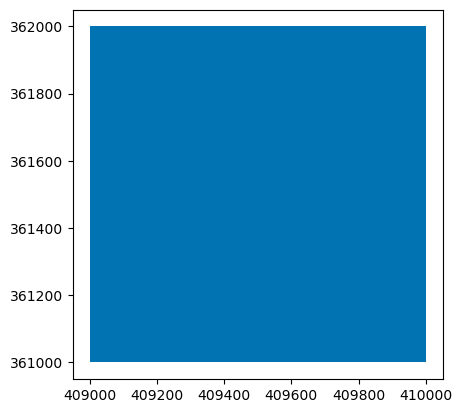

In [191]:
df_tiles_eval[df_tiles_eval['PLAN_NO'] == 'SK0961'].plot()

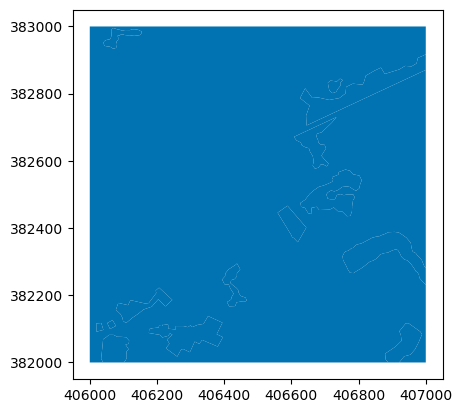

In [196]:
dict_dict_intersect_eval['22']['SK0682'].plot()

['Wood and Forest Land', 'Moor and Heath Land', 'Agro-Pastoral Land', 'Water and Wetland', 'Rock and Coastal Land', 'Developed Land', 'Unclassified Land']
80s 49957868.73755686
22 50000602.540111504
0.042733802554641556


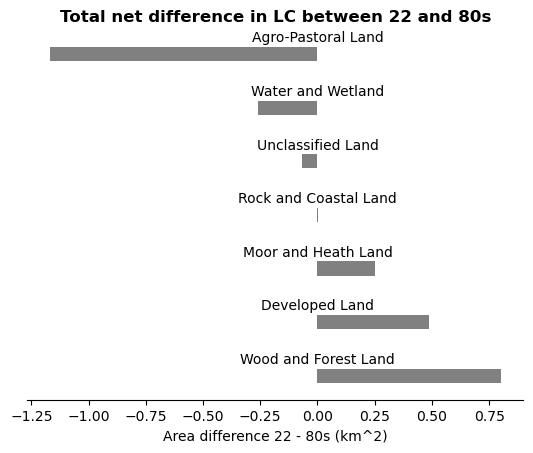

In [145]:
tmp = lcv.plot_difference_total_lc_from_dfs(dict_dfs=dict_df_eval_tiles_lc)

In [109]:
dict_df_eval_tiles_lc['22'] = dict_df_eval_tiles_lc['22'].iloc[np.where(dict_df_eval_tiles_lc['22']['Class name'] == '')[0]].assign(Class_Code='I')

In [140]:
dict_df_eval_tiles_lc['22']

,geometry,Class_Code,area,Class name
0,"POLYGON ((405000.003 403999.995, 405999.997 40...",D,9.999877e+05,Moor and Heath Land
1,"POLYGON ((406999.999 404999.999, 406999.999 40...",D,1.000006e+06,Moor and Heath Land
2,"POLYGON ((409000.004 400238.118, 408962.818 40...",I,8.873818e+05,Unclassified Land
3,"POLYGON ((408936.044 400000.000, 408937.694 40...",C,2.264764e+03,Wood and Forest Land
4,"POLYGON ((408684.824 400000.000, 408684.522 40...",E,1.092942e+05,Agro-Pastoral Land
...,...,...,...,...
370,"POLYGON ((424328.731 396999.999, 424328.142 39...",E,2.051922e+04,Agro-Pastoral Land
371,"POLYGON ((424364.416 395999.995, 424357.222 39...",E,3.344872e+05,Agro-Pastoral Land
372,"POLYGON ((424139.248 396228.554, 424138.529 39...",C,4.321682e+05,Wood and Forest Land
373,"POLYGON ((424115.392 396237.780, 424181.401 39...",D,5.338676e+04,Moor and Heath Land


# TODO
- Take intersection of pols and PD outline. Then leave No CLass/unclassified as a label 
- Total net gain/loss per LC (horizontal bar plot; sum pol areas)
- Gain & loss per pair of LCs. (Confusion matrix; loop through old pols and find intersection with new & add to count of new area)
